In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power, eigh
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# **Diffusion Map algorithm**

---



In [2]:
def getDistanceMap(dataMatrix):
  '''
  Calculate the distance matrix 
  :param dataMatrix: data set that for which the diffusion map should be generated
  :return: distance matrix of the given data set
  '''
  return distance_matrix(dataMatrix, dataMatrix)

In [3]:
def getKernelMatrix(distances, eps):
  '''
  Generating the kernel matrix
  :param distances: distance matrix of the data set
  :param eps: epsilon value of the algorithm
  :return: kernel matrix
  '''
  return np.exp(-np.square(distances) / eps)

In [4]:
def getDiagonalNormMatrix(kernel):
  '''
  Computing the diagonal normalization matrix 
  :param kernel: kernel that is to be normalized
  :return: diagonal normalization matrix of the given kernel
  '''
  summed = np.sum(kernel, axis=1)
  return np.identity(len(summed)) * np.outer(np.ones(len(summed)), summed)

In [5]:
def diffusionMap(dataMatrix, l):
  '''
  Conpute the diffusion map of a data set
  :param dataMatrix: data set for which the diffusion map is to be computed
  :param l: the dimension of the map
  :return: eigenvalues and eigenvectors according to the given algorithm 
  '''
  # Step 1: computing the distance matrix
  distanceMap = getDistanceMap(dataMatrix)
  # Step 2: setting the epsilon value of the algorithm
  eps = 0.05 * max(distanceMap.flatten())
  # Step 3: forming the kernel matrix W
  kernel_w = getKernelMatrix(distanceMap, eps)
  # Step 4: computing the diagonal normalization matrix P
  diag_p = getDiagonalNormMatrix(kernel_w)
  diag_p_inv = fractional_matrix_power(diag_p, -1)
  # Step 5: normalize W to get K
  kernel_norm_k = diag_p_inv @ kernel_w @ diag_p_inv
  # Step 6: computing the diagonal normalization matrix Q
  diag_norm_q = getDiagonalNormMatrix(kernel_norm_k)
  diag_norm_q_trans = fractional_matrix_power(diag_norm_q, -0.5)
  # Step 7: form the symmetric matrix T_hat
  symmetric_t = diag_norm_q_trans @ kernel_norm_k @ diag_norm_q_trans
  # Step 8: computing the l + 1 largest eigenvalues and corresponding eigenvectors of T_hat
  dim_symm = len(symmetric_t)
  eigenvalues_a, eigenvectors_v = eigh(symmetric_t, eigvals=[dim_symm - l - 1, dim_symm - 1])
  # Step 9: compute the eigenvalues of T_hat^(1/eps) according to the formula
  compute_eigenvalues = np.vectorize(lambda x: x ** (1 / eps))
  used_eigenvalues_squared = compute_eigenvalues(eigenvalues_a)
  # Step 10: compute the eigenvectors of T according to the formula
  used_eigenvectors = np.apply_along_axis(lambda x: diag_norm_q_trans @ x, 0, eigenvectors_v)

  # reversing since eigh computes the values in ascending order
  return used_eigenvalues_squared[::-1], used_eigenvectors[:, ::-1]

# **Part One**
---

In [6]:
N = 1000
generate_tk = np.vectorize(lambda x: 2 * np.pi * x / (N + 1))
tk = generate_tk(np.arange(1, N + 1))
X_part1 = np.array([[np.cos(t), np.sin(t)] for t in tk])

In [7]:
l = 5
_, eigenfunctions_part1 = diffusionMap(X_part1, l)

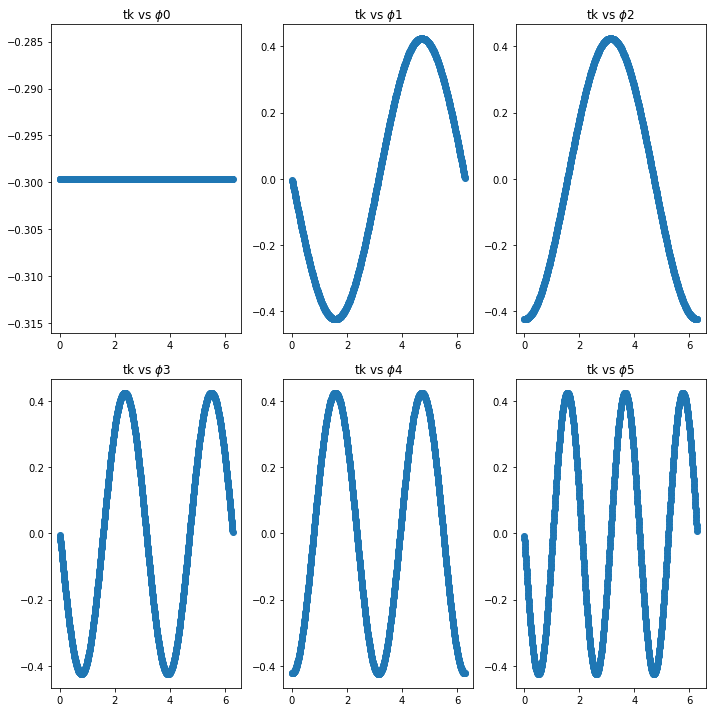

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3)

getvector_by_index = lambda index: np.around(eigenfunctions_part1[:, index], decimals=8)
for index, ax in enumerate(axes.flatten()):
  ax.scatter(tk, getvector_by_index(index))
  ax.figure.set_size_inches(10, 10)
  ax.set_title(rf'tk vs $\phi{index}$')

plt.tight_layout()

# **Part Two**

---


### **With 5000 samples**

In [9]:
n_samples = 5000

nr_samples_plot = 1000
idx_plot= np.random.permutation(n_samples)[0:nr_samples_plot]

Text(0.5, 0, 'z')

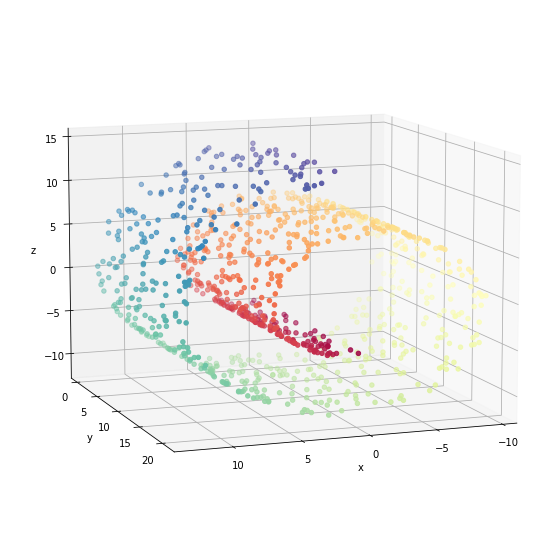

In [30]:
# Generate the swiss roll data set
X_part2, t_part2 = make_swiss_roll(n_samples)

# plotting the swiss roll data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_part2[idx_plot, 0], X_part2[idx_plot, 1], X_part2[idx_plot, 2], c=t_part2[idx_plot], cmap=plt.cm.Spectral)
ax.view_init(10,70)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [31]:
l = 10
eigenvalues_part2, eigenfunctions_part2 = diffusionMap(X_part2, l)

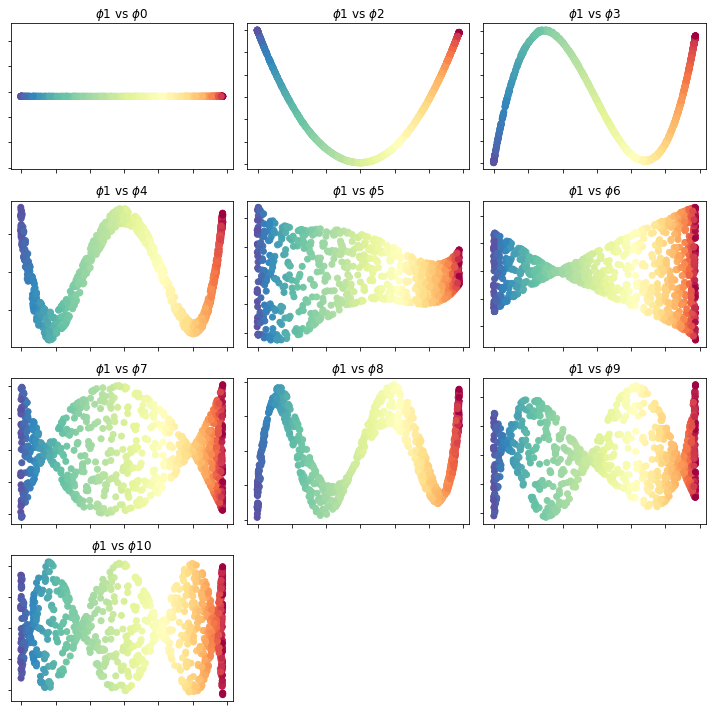

In [32]:
fig, axes = plt.subplots(nrows=int(np.ceil(l / 3.0)), ncols=3)

# filtering which points shall be plotted based on idx_plot
plotting_eigenvectors = np.around(eigenfunctions_part2[idx_plot, :], decimals=8)
# selecting the first non-constant eigenfunction
phi_one = plotting_eigenvectors[:, 1]
for index, ax in enumerate(axes.flatten()[:l]):
  if index == 0:
    index_label = 0
  else:
    index_label = index + 1
  phi_index = plotting_eigenvectors[:, index_label]
  ax.scatter(phi_one, phi_index, c=t_part2[idx_plot], cmap=plt.cm.Spectral)
  ax.figure.set_size_inches(10, 10)
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  ax.set_title(rf'$\phi 1$ vs $\phi{index_label}$')

# deleting empty plots
for i in range(0, -l % 3):
  fig.delaxes(axes[-1][-i - 1])
plt.tight_layout()

In [33]:
# used to get the three principal components of the swiss roll data set
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_part2)
print(pca.explained_variance_ratio_)
print(pca.components_)

[0.39289211 0.32074279 0.2863651 ]
[[ 0.51253823 -0.04561529  0.85745193]
 [-0.85851854 -0.04562882  0.5107484 ]
 [ 0.01582658 -0.99791646 -0.06254809]]


Text(0, 0.5, 'Second component')

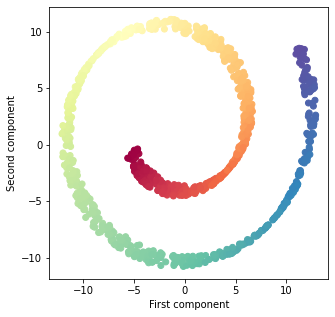

In [34]:
pca_two = PCA(n_components=2)
pca_two.fit(X_part2)
X_part2_pca = pca_two.transform(X_part2)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(X_part2_pca[idx_plot, 0], X_part2_pca[idx_plot, 1], c=t_part2[idx_plot], cmap=plt.cm.Spectral)
ax.set_xlabel('First component')
ax.set_ylabel('Second component')

### **With 1000 samples**

In [35]:
n_samples_1000 = 1000

nr_samples_plot_1000 = 1000
idx_plot_1000 = np.random.permutation(n_samples_1000)[0:nr_samples_plot_1000]

Text(0.5, 0, 'z')

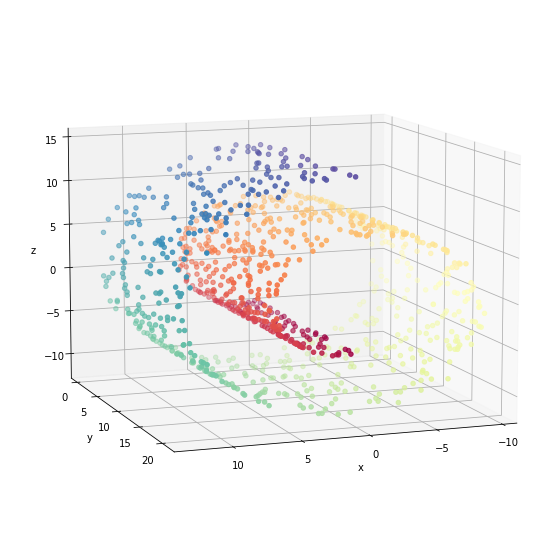

In [51]:
# Generate the swiss roll data set
X_part2_1000, t_part2_1000 = make_swiss_roll(n_samples_1000)

# plotting the swiss roll data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_part2_1000[idx_plot_1000, 0], X_part2_1000[idx_plot_1000, 1], 
           X_part2_1000[idx_plot_1000, 2], c=t_part2_1000[idx_plot_1000], 
           cmap=plt.cm.Spectral)
ax.view_init(10,70)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [52]:
l = 10
eigenvalues_part2_1000, eigenfunctions_part2_1000 = diffusionMap(X_part2_1000, l)

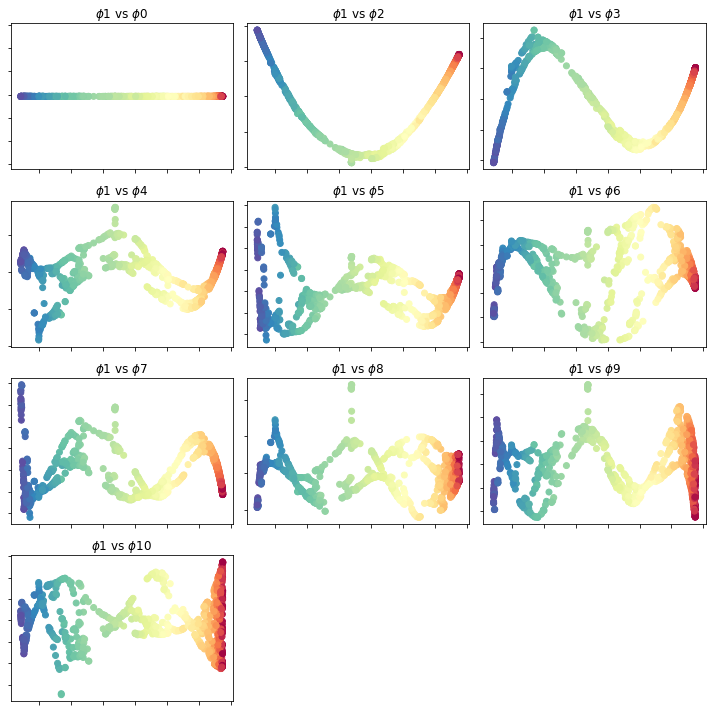

In [53]:
fig, axes = plt.subplots(nrows=int(np.ceil(l / 3.0)), ncols=3)

# filtering which points shall be plotted based on idx_plot
plotting_eigenvectors_1000 = np.around(eigenfunctions_part2_1000[idx_plot_1000, :], decimals=8)
# selecting the first non-constant eigenfunction
phi_one_1000 = plotting_eigenvectors_1000[:, 1]
for index, ax in enumerate(axes.flatten()[:l]):
  if index == 0:
    index_label = 0
  else:
    index_label = index + 1
  phi_index = plotting_eigenvectors_1000[:, index_label]
  ax.scatter(phi_one_1000, phi_index, c=t_part2_1000[idx_plot_1000], cmap=plt.cm.Spectral)
  ax.figure.set_size_inches(10, 10)
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  ax.set_title(rf'$\phi 1$ vs $\phi{index_label}$')

# deleting empty plots
for i in range(0, -l % 3):
  fig.delaxes(axes[-1][-i - 1])
plt.tight_layout()

In [54]:
# used to get the three principal components of the swiss roll data set
from sklearn.decomposition import PCA
pca_1000 = PCA(n_components=3)
pca_1000.fit(X_part2_1000)
print(pca_1000.explained_variance_ratio_)
print(pca_1000.components_)

[0.40206783 0.30775686 0.29017531]
[[ 0.47099923  0.03711366  0.88135254]
 [-0.75924722 -0.49161595  0.42644743]
 [-0.44911399  0.87002088  0.20337229]]


Text(0, 0.5, 'Second component')

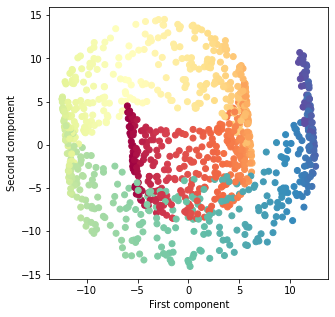

In [55]:
pca_two_1000 = PCA(n_components=2)
pca_two_1000.fit(X_part2_1000)
X_part2_pca_1000 = pca_two_1000.transform(X_part2_1000)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(X_part2_pca_1000[idx_plot_1000, 0], X_part2_pca_1000[idx_plot_1000, 1], 
           c=t_part2_1000[idx_plot_1000], cmap=plt.cm.Spectral)
ax.set_xlabel('First component')
ax.set_ylabel('Second component')

# **Part Three**
---

In [21]:
# loading the vadere data
f = open('data_DMAP_PCA_vadere.txt', 'r')
content = f.readlines()

# prepare data
data_set = list()
for line in content:
    line = line[:-1].split(' ')
    time_step = list(line)
    data_set.append(time_step)
data_set = np.array(data_set, dtype='float64')

Text(0.5, 0, 'y')

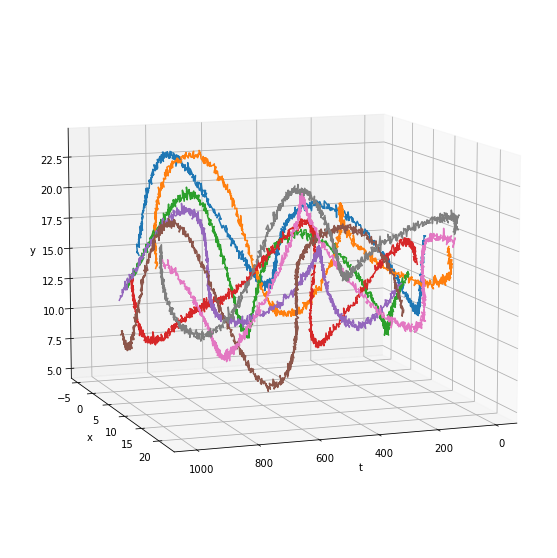

In [22]:
# plotting the data set depnding on the timestep
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

time_finish = 1000
time = np.linspace(0, time_finish, time_finish)
for i in range(8):
  ax.plot(time, data_set[:, 2*i][:time_finish], data_set[:, 2*i + 1][:time_finish])

ax.view_init(10,70)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("y")

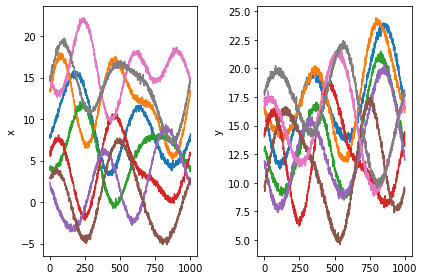

In [23]:
# plotting the data depending on time step and projected onto x and y
fig, [ax, ax1] = plt.subplots(nrows=1, ncols=2)
time_finish = 1000
time = np.linspace(0, time_finish, time_finish)
for i in range(8):
  ax.plot(time, data_set[:, 2*i][:time_finish])
  ax1.plot(time, data_set[:, 2*i+1][:time_finish])

ax.set_ylabel("x")
ax1.set_ylabel("y")
plt.tight_layout()

In [24]:
l = 999
eigenvalues_part3, eigenfunctions_part3 = diffusionMap(data_set, l)

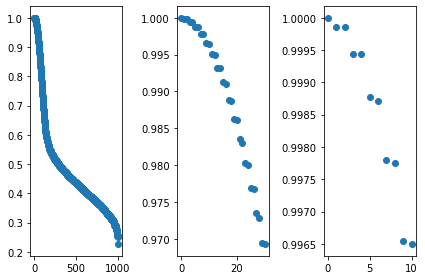

In [25]:
# showing the eigenvalues
fig, [ax, ax1, ax2] = plt.subplots(ncols=3)
elements = np.linspace(0, l, l+1)
ax.scatter(elements, eigenvalues_part3)
ax1.scatter(elements[:31], eigenvalues_part3[:31])
ax2.scatter(elements[:11], eigenvalues_part3[:11])
plt.tight_layout()

Text(0, 0.5, 'Second component')

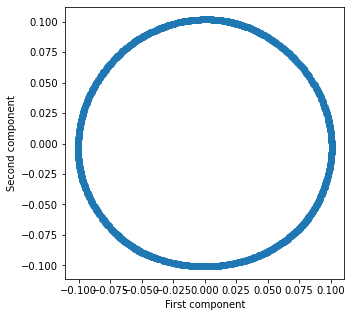

In [26]:
# projecting the data set onto its first two components
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
getDiffusion = lambda index: eigenvalues_part3[index] * eigenfunctions_part3[:, index] 
ax.scatter(getDiffusion(1), getDiffusion(2))
ax.set_xlabel('First component')
ax.set_ylabel('Second component')

# **Datafold**
---

In [56]:
import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.utils.plot import plot_pairwise_eigenvector

In [57]:
X_pcm = pfold.PCManifold(X_part2)

distanceMap = getDistanceMap(X_pcm)
X_pcm.kernel.epsilon = 0.05 * max(distanceMap.flatten())
print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

epsilon=1.6250276639953114, cut-off=inf


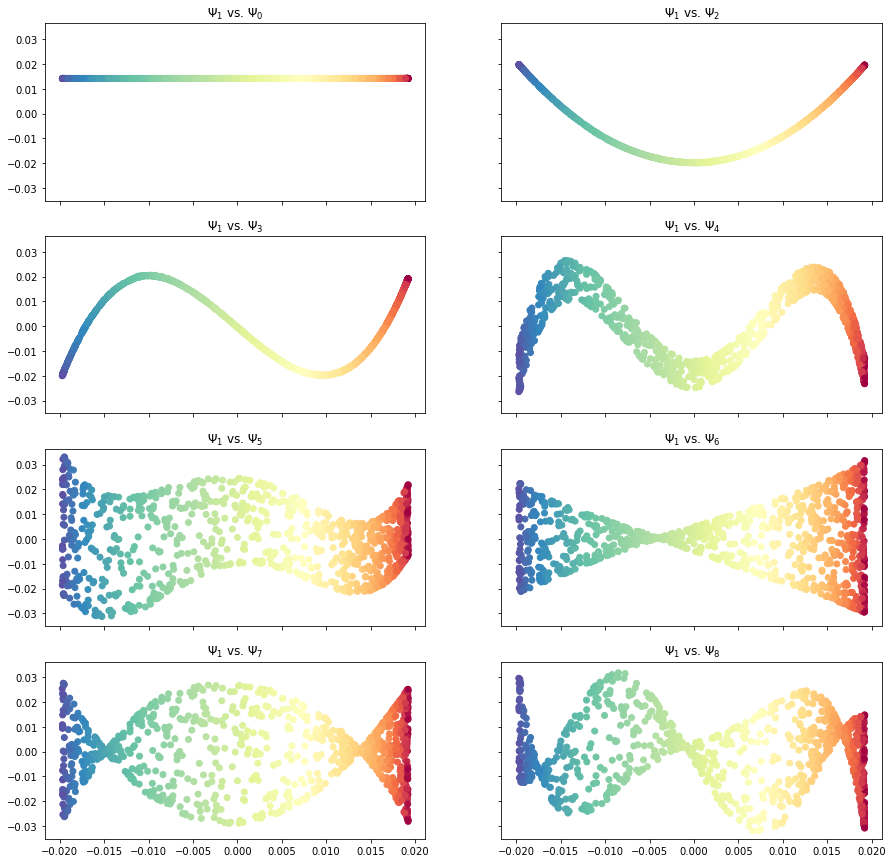

In [58]:
dmap = dfold.DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                           n_eigenpairs=9,
                           dist_kwargs=dict(cut_off=X_pcm.cut_off))
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[idx_plot, :], n=1,
                          fig_params=dict(figsize=[15,15]),
                          scatter_params=dict(cmap=plt.cm.Spectral, c=t_part2[idx_plot]))